1. Nettoyage
2. Analyse des variables
3. Encodage (OneHot, LabelEncoder...)
4. Normalisation (et centrage)
5. Split données
6. Fit sur X_train, y_train 
7. Score sur X_test, y_test

**Améliorations:**
1. Catégoriser
2. PolynomialFeatures
3. Suppression des outliers influants avec la distance de Cook
4. CrossValidation

In [49]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [50]:
df = pd.read_csv('data/df_clean.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.2+ KB


# Split des data

In [51]:
df.sex = df.sex.astype('category')
df.smoker = df.smoker.astype('category')
df.region = df.region.astype('category')

y = df['charges']
df = df.drop('charges', axis=1)
X = df[['age', 'sex', 'bmi', 'children', 'smoker', 'region']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=.85, stratify=X['smoker'], shuffle=True)
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('y_train', X_train.shape)
print('y_test', X_test.shape)

X_train (1136, 6)
X_test (201, 6)
y_train (1136, 6)
y_test (201, 6)


Text(0.5, 1.0, 'Charges (check de la normalité)')

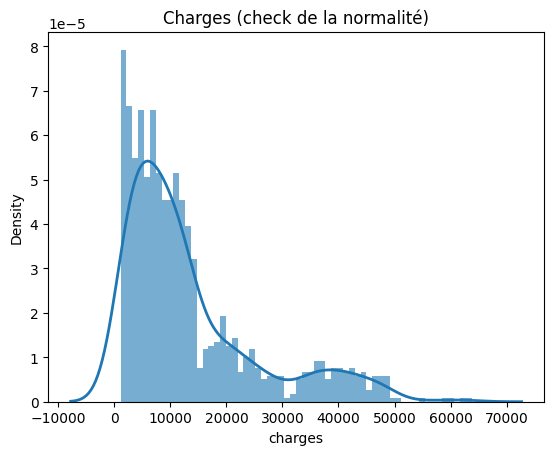

In [52]:
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})
sns.distplot(y_train, norm_hist=True, bins=60, **kwargs)
plt.title('Charges (check de la normalité)')

# Test entre 2 méthodes

### init

In [53]:

from sklearn import set_config
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.linear_model import Lasso, LassoCV, LinearRegression

from feature_engine.encoding import OneHotEncoder, OrdinalEncoder
from feature_engine.discretisation import ArbitraryDiscretiser

set_config(transform_output = "pandas")

alphas = np.linspace(10, 200, 30)
l1_ratio = np.linspace(0.1, 1, 10)
bmi_dict = {'bmi': [0, 18.5, 25, 30, 40, np.Inf]}

## Pipeline

In [54]:
from sklearn.pipeline import FunctionTransformer
from utils import bmi_transform

get_bmi = FunctionTransformer(bmi_transform)

pipe_bmi = make_pipeline(
    get_bmi,
    OneHotEncoder(variables=['bmi'])
)

transformers = make_column_transformer(
    (OneHotEncoder(variables=['region']), ['region']),
    (OrdinalEncoder(variables=['smoker', 'sex']), ['smoker', 'sex']),
    (pipe_bmi, ['bmi']),
    remainder='passthrough'
)

pipeline = make_pipeline(
    transformers,
    PolynomialFeatures(), 
    StandardScaler(),
)

pipeline.fit(X_train, y_train)

df_X_train = pipeline.fit_transform(X_train, y_train)
df_X_train.head()

,1,onehotencoder__region_northeast,onehotencoder__region_southwest,onehotencoder__region_northwest,onehotencoder__region_southeast,ordinalencoder__smoker,ordinalencoder__sex,pipeline__bmi_3.0,pipeline__bmi_2.0,pipeline__bmi_0.0,...,pipeline__bmi_0.0^2,pipeline__bmi_0.0 pipeline__bmi_1.0,pipeline__bmi_0.0 remainder__age,pipeline__bmi_0.0 remainder__children,pipeline__bmi_1.0^2,pipeline__bmi_1.0 remainder__age,pipeline__bmi_1.0 remainder__children,remainder__age^2,remainder__age remainder__children,remainder__children^2
1094,0.0,1.760989,-0.561084,-0.558371,-0.622139,-0.507965,-1.017763,0.920410,-0.620778,-0.126886,...,-0.126886,0.0,-0.119600,-0.085899,-0.443903,-0.413309,-0.28986,-1.249466,0.576398,3.248930
94,0.0,-0.567863,1.782266,-0.558371,-0.622139,1.968638,-1.017763,0.920410,-0.620778,-0.126886,...,-0.126886,0.0,-0.119600,-0.085899,-0.443903,-0.413309,-0.28986,2.094835,1.694909,0.341083
349,0.0,-0.567863,-0.561084,1.790924,-0.622139,-0.507965,0.982547,-1.086472,1.610881,-0.126886,...,-0.126886,0.0,-0.119600,-0.085899,-0.443903,-0.413309,-0.28986,-1.216661,-0.861687,-0.628199
410,0.0,-0.567863,-0.561084,1.790924,-0.622139,-0.507965,0.982547,-1.086472,-0.620778,7.881060,...,7.881060,0.0,4.751044,-0.085899,-0.443903,-0.413309,-0.28986,-1.216661,-0.861687,-0.628199
981,0.0,-0.567863,1.782266,-0.558371,-0.622139,1.968638,0.982547,-1.086472,1.610881,-0.126886,...,-0.126886,0.0,-0.119600,-0.085899,-0.443903,-0.413309,-0.28986,-0.684694,0.995839,1.552686


# Cook distance

## Visualisation

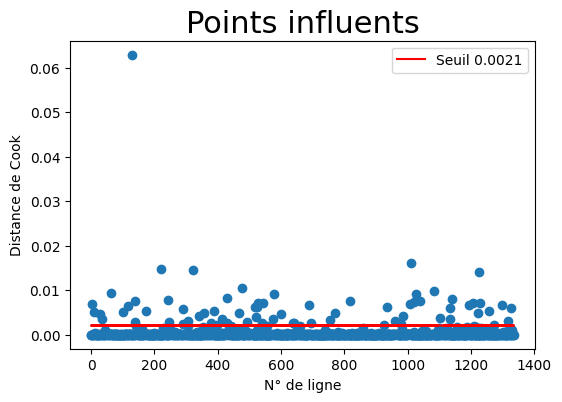

In [55]:
import statsmodels.api as sm

y_train_cook = y_train.copy()

df_X_train = sm.add_constant(df_X_train)
model_cook = sm.OLS(y_train_cook, df_X_train).fit()
influence = model_cook.get_influence()

coef_limit = 4
#obtain Cook's distance for each observation
cooks = influence.cooks_distance 
mean_cooks = np.mean(cooks[0])
mean_cooks_list = [coef_limit * mean_cooks for i in df_X_train.index]
# Draw plot
plt.figure(figsize = (6, 4))
plt.scatter(df_X_train.index, cooks[0])
#plt.plot(df_X_train.index, cooks[0], color='black')
plt.plot(df_X_train.index, mean_cooks_list, color="red", label=f'Seuil {round(coef_limit * mean_cooks, 4)}')
plt.xlabel('N° de ligne', fontsize = 10)
plt.ylabel('Distance de Cook', fontsize = 10)
plt.title('Points influents', fontsize = 22)
plt.legend()
plt.show()


## Points d'influence

In [56]:
# Influencial points
influencial_points = df_X_train.index[cooks[0] > coef_limit * mean_cooks]
influencial_points

Index([ 491,  468,  598, 1257,  526,  769,  306,   34, 1011,  524,  986, 1205,
        476, 1026,  958,  818,  305,  387,  430,  516,  289,  636,  543, 1317,
       1194,  640,  219,  397, 1271, 1141, 1103, 1007,  412,  172,  979,  340,
       1229, 1084, 1222, 1225,  102,  140, 1327,  321,  924,  355, 1132, 1018,
        573,  520,  753,  687,    9,  115,  128,  138,  242,  291,  695,  577,
        380,    3, 1299,   62,  539, 1038,  429,   28,  245,  935, 1133],
      dtype='int64')

## Suppression des points d'influence
Ne pas le faire sur le jeu de test

In [57]:
print(len(X_train), len(y_train), f'suppression de : {len(influencial_points)} points')

X_train.drop(index=influencial_points, inplace=True)
y_train.drop(index=influencial_points, inplace=True)

print(len(X_train), len(y_train))

1136 1136 suppression de : 71 points
1065 1065


# Regression linéaire

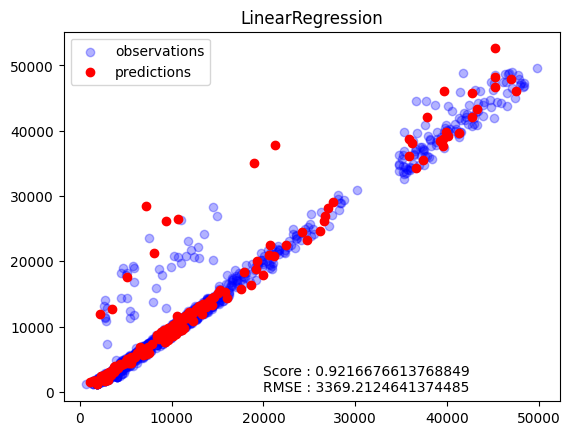

In [58]:
from sklearn.linear_model import LinearRegression

pipe = make_pipeline(
                    pipeline,
                    LinearRegression()
                )

pipe.fit(X_train, y_train)
score = pipe.score(X_test, y_test)

predictions = pipe.predict(X_test)
mse = mean_squared_error(y_test, predictions, squared=False)

observations = pipe.predict(X_train)
plt.title('LinearRegression')
plt.text(s=f'Score : {score} \nRMSE : {mse}', y=-1, x=20000)

plt.scatter(observations, y_train, color='blue', alpha=.3, label='observations')
plt.scatter(predictions, y_test, color='red', label='predictions')
plt.legend()

# ElasticNet

In [59]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet

pipe = make_pipeline(
                    pipeline, 
                    ElasticNet(max_iter=100000,random_state=42)
                )
#print(pipe.get_params()) --> pour récupérer les paramètres pour le cv du modèle
# pipe.fit(X_train, y_train)
# pipe.score(X_test, y_test)

grid = GridSearchCV(pipe, {'elasticnet__alpha': np.arange(149,152,0.1), 'elasticnet__l1_ratio': [1]}, cv=5)

grid.fit(X_train, y_train)
best = grid.best_estimator_

Text(10000, -1, "Score : 0.9247985985086979 \nRMSE : 3301.192270199304 \nbest params : {'elasticnet__alpha': 149.0, 'elasticnet__l1_ratio': 1}")

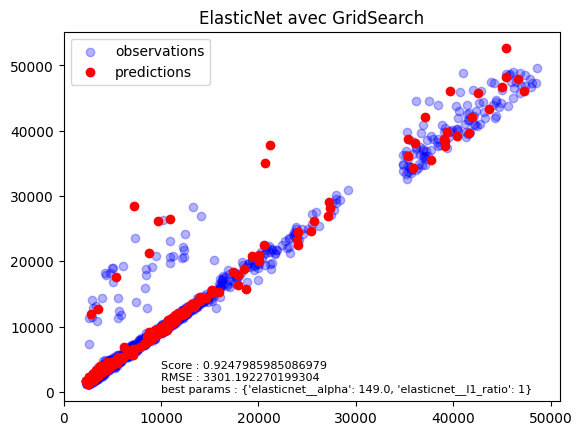

In [60]:
predictions = best.predict(X_test)
mse = mean_squared_error(y_test, predictions, squared=False)

observations = best.predict(X_train)
plt.scatter(observations, y_train, color='blue', alpha=.3, label='observations')
plt.scatter(predictions, y_test, color='red', label='predictions')
plt.legend()
plt.title('ElasticNet avec GridSearch')
plt.text(s=f'Score : {best.score(X_test, y_test)} \nRMSE : {mse} \nbest params : {grid.best_params_}', y=-1, x=10000, fontsize=8)

# GridSearchCV

In [61]:
from sklearn.model_selection import GridSearchCV

pipe = make_pipeline(
                    pipeline,
                    Lasso()
                )
#print(pipe.get_params()) --> pour récupérer les paramètres pour le cv du modèle
grid = GridSearchCV(pipe, {'lasso__alpha': alphas}, cv=5)
grid.fit(X_train, y_train)
best = grid.best_estimator_

Text(13000, -1, "Score : 0.9229554679717329 \nRMSE : 3341.40226853576 \nbest params : {'lasso__alpha': 23.10344827586207}")

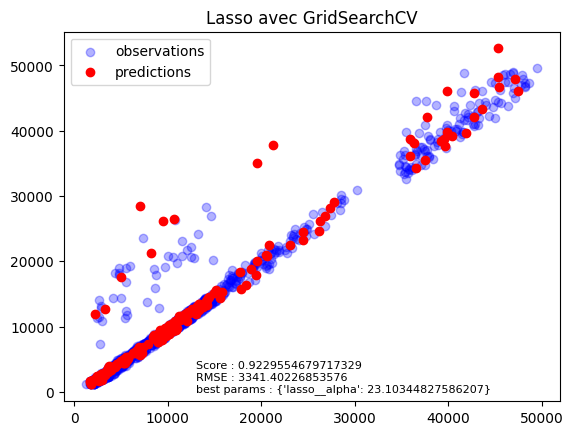

In [62]:
predictions = best.predict(X_test)
mse = mean_squared_error(y_test, predictions, squared=False)

predictions = grid.best_estimator_.predict(X_test)
observations = grid.best_estimator_.predict(X_train)

plt.scatter(observations, y_train, color='blue', alpha=.3, label='observations')
plt.scatter(predictions, y_test, color='red', label='predictions')
plt.legend()
plt.title('Lasso avec GridSearchCV')
plt.text(s=f'Score : {best.score(X_test, y_test)} \nRMSE : {mse} \nbest params : {grid.best_params_}', y=-1, x=13000, fontsize=8)

### Sauvegarde du model

In [63]:
from joblib import dump, load

model_path = 'data/model_grid.joblib'
dump(best, model_path) 

# test chragement du modele
m = load(model_path)
model = m

# test predict sur un individu
t = pd.DataFrame(
                [['no', 'male', 18, 15.0, 0, 'northeast']], 
                 columns = ['smoker', 'sex', 'age', 'bmi', 'children', 'region']
                 )
print(t.head())
model.predict(t)

  smoker   sex  age   bmi  children     region
0     no  male   18  15.0         0  northeast


array([1760.83832064])

## LassoCV

In [64]:
pipe = make_pipeline(
            transformers,
            PolynomialFeatures(), 
            StandardScaler(),
            LassoCV(alphas=alphas, cv=5)
        )

pipe.fit(X_train, y_train)
score = pipe.score(X_test, y_test)
predictions = pipe.predict(X_test)
mse = mean_squared_error(y_test, predictions, squared=False)
#print(pipe.named_steps)
print('Score :', score)
print('RMSE :', mse)
print('alpha :', pipe.named_steps.lassocv.alpha_)

Score : 0.9229554679717329
RMSE : 3341.40226853576
alpha : 23.10344827586207


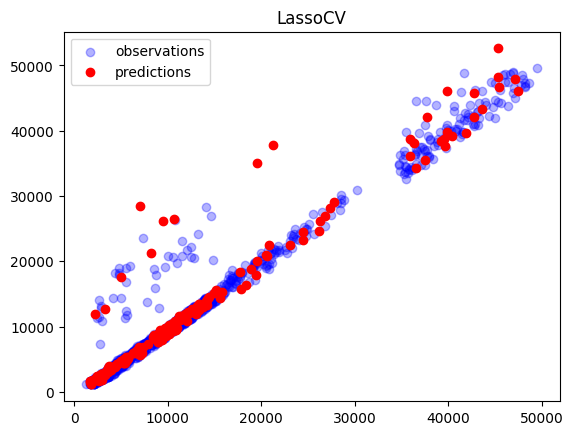

In [65]:
predictions = pipe.predict(X_test)
observations = pipe.predict(X_train)

plt.scatter(observations, y_train, color='blue', alpha=.3, label='observations')
plt.scatter(predictions, y_test, color='red', label='predictions')
plt.title('LassoCV')
plt.legend()

### Sauvegarde du model

In [66]:
from joblib import dump

model_path = 'data/model_lassocv.joblib'
dump(best, model_path)

# test chragement du modele
m = load(model_path)
model = m

# test predict sur un individu
t = pd.DataFrame(
                [['no', 'male', 18, 15.0, 0, 'northeast']], 
                 columns = ['smoker', 'sex', 'age', 'bmi', 'children', 'region']
                 )
print(t.head())
model.predict(t)

  smoker   sex  age   bmi  children     region
0     no  male   18  15.0         0  northeast


array([1760.83832064])

### Graph des prédictions

# Discrétisation de bmi pour la démo

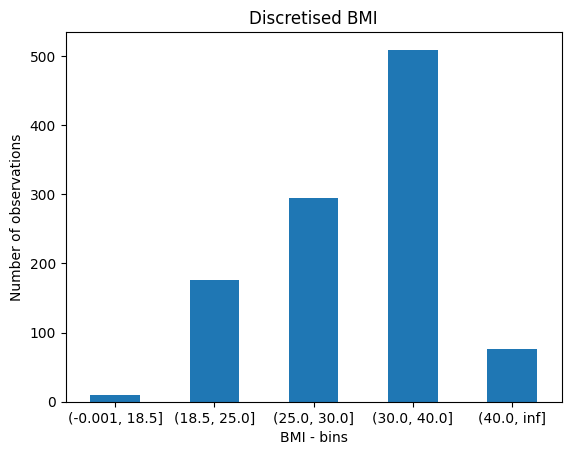

In [67]:
from feature_engine.discretisation import ArbitraryDiscretiser

bmi_dict = {'bmi': [0, 18.5, 25, 30, 40, np.Inf]}
transformer = ArbitraryDiscretiser(binning_dict=bmi_dict, return_object=False, return_boundaries=True)

bmi = transformer.fit_transform(X_train)
bmi['bmi'].value_counts(ascending=True).sort_index().plot.bar(rot=0)
plt.xlabel('BMI - bins')
plt.ylabel('Number of observations')
plt.title('Discretised BMI')
plt.show()

# chargement du model et prédiction

In [70]:
model_path = 'data/model_grid.joblib'
model = load(model_path)

# test predict sur un individu
t = pd.DataFrame(
                [['no', 'male', 18, 15.0, 0, 'northeast']], 
                 columns = ['smoker', 'sex', 'age', 'bmi', 'children', 'region']
                 )
print(t.head())
model.predict(t)


  smoker   sex  age   bmi  children     region
0     no  male   18  15.0         0  northeast


array([1760.83832064])